In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
!pip freeze > requirements.txt

# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-10-01'

In [9]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            #'token_all_activity_3H': [0, 30],
            #'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664992771,52170,39930,cancel,0x4eeec9917f0978d568e890eee27683769d03ba35,NaN,NaN,sneakers,common,ranger,...,0.55,0.55,0.55,10.0,11.0,318.0,509.0,562.0,98.0,660.0
1,1664992675,52077,49418,cancel,0x720963b0e3f02afafa78c50c8312854080c26c9b,NaN,NaN,sneakers,uncommon,hiker,...,1.89,1.89,0.55,8.0,13.0,43.0,51.0,562.0,98.0,660.0
2,1664992675,52408,57609,sell,0x64d90e3b7771b6ee24a829196ce805f802ca0f77,NaN,0.65,sneakers,common,sprinter,...,0.55,0.55,0.55,143.0,188.0,317.0,508.0,562.0,98.0,660.0
3,1664992660,52361,57609,cancel,0x64d90e3b7771b6ee24a829196ce805f802ca0f77,NaN,NaN,sneakers,common,sprinter,...,0.55,0.55,0.55,144.0,189.0,318.0,509.0,563.0,98.0,661.0
4,1664992639,52074,47741,cancel,0x720963b0e3f02afafa78c50c8312854080c26c9b,NaN,NaN,sneakers,uncommon,ranger,...,1.89,1.89,0.55,18.0,18.0,44.0,52.0,564.0,98.0,662.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76980,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76981,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76982,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76983,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76985 entries, 0 to 76984
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  44295 non-null  float64
 1   time_ownership             44295 non-null  float64
 2   wallet_box_mint            44295 non-null  float64
 3   wallet_sneaker_mint        44295 non-null  float64
 4   time_level_up              49264 non-null  float64
 5   time_level_up_for_mint     53197 non-null  float64
 6   base_mint_price_amt        53197 non-null  float64
 7   base_mint_price_azy        53197 non-null  float64
 8   base_mint_price_bnb        43174 non-null  float64
dtypes: float64(9)
memory usage: 5.3 MB


In [13]:
data.genesis

0        False
1        False
2        False
3        False
4        False
         ...  
76980     True
76981    False
76982    False
76983    False
76984     True
Name: genesis, Length: 76985, dtype: bool

In [14]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
16,1664992315,50855,60565,buy,0xb03ef39784640c2a7014fcec8697998953c02d04,0xd9a2b07edbbbf1e3f25106ed84bc82e77cab243e,0.61,sneakers,common,ranger,...,0.55,0.55,0.55,146.0,191.0,320.0,514.0,574.0,98.0,672.0
21,1664992207,51502,28433,buy,0xeeab85f8b9497c14de336917a8f1d17b0314d60f,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,517.0,577.0,98.0,675.0
24,1664992117,51901,24899,buy,0x37211560d9fa9f802ea152254395f03aff4f2a37,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,516.0,576.0,99.0,675.0
28,1664992003,52402,60796,buy,0x0d0f18a1c24ff2209b1ccf95eedda78f337f8694,0x1bb4263f60e09f368feefa779588d4aaf530fe42,0.55,sneakers,common,hiker,...,0.55,0.55,0.55,147.0,191.0,319.0,518.0,579.0,99.0,678.0
53,1664991450,52393,48145,buy,0xee1abb84fbe1dcaf058ef38d62de5c36c0e0a201,0x7201fa9c469fcb69e5a1c4ad3b68005946eba0c8,0.57,sneakers,common,ranger,...,0.56,0.56,0.56,145.0,189.0,320.0,522.0,586.0,99.0,685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76922,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76945,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76959,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76964,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [15]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
sell_count_24H more then expected. get: 2156 | expected: 2000
cancel_count_24H more then expected. get: 1769 | expected: 1000


In [16]:
data['mint'].isna().sum()

0

In [17]:
data[data['level'] == 9]['mint'].value_counts()

2.0    271
0.0     77
3.0     65
1.0     36
4.0      3
Name: mint, dtype: int64

In [18]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
145,1664987287,52357,25036,buy,0x3fc589e36bf29323519f49a37dad4219b2334071,0xd1c26da45a9cb578a4511d9bdae8b34e5cf29cd2,1.40,sneakers,common,hiker,...,0.63,0.52,0.52,8.0,20.0,205.0,540.0,604.0,98.0,702.0
238,1664983866,52161,18335,buy,0x92dd9ba72f98e106c63481d725032ce0993abc4f,0x0b11130eff89443e96eeb458cc71f9937766519d,1.00,sneakers,common,ranger,...,0.00,0.00,0.00,7.0,11.0,219.0,560.0,624.0,99.0,723.0
365,1664979902,52247,55458,buy,0x5dd67de27f5999d838cfa8deb5778b4bfcdae245,0x466e352a106c81cb0590ed8d4165c78cbac5f6f0,3.89,sneakers,uncommon,ranger,...,1.89,1.89,0.50,1.0,1.0,51.0,59.0,626.0,98.0,724.0
368,1664979800,52243,57772,buy,0x82023469ad1086dcb6fdcd5321bcf12f13605ce0,0xecafa35d3c26f680f4b399d3b50b170be4eff631,3.78,sneakers,uncommon,hiker,...,1.89,1.89,0.50,2.0,3.0,52.0,60.0,625.0,98.0,723.0
376,1664979362,52231,45259,buy,0x093b8607b9e6dafb5d42e0c860701f71f33273c8,0x3bb3e69e2d55d6374b3bc421da6d70ec0b0647a7,2.65,sneakers,uncommon,ranger,...,1.89,1.89,0.52,1.0,3.0,53.0,61.0,619.0,98.0,717.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72357,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73133,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74286,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74647,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13346 entries, 16 to 76978
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        13346 non-null  int64  
 1   mrk_id                                           13346 non-null  int64  
 2   token_id                                         13346 non-null  int64  
 3   event                                            13346 non-null  object 
 4   wallet_from                                      13308 non-null  object 
 5   wallet_to                                        13346 non-null  object 
 6   price                                            13346 non-null  float64
 7   item_type                                        13346 non-null  object 
 8   rarity                                           13346 non-null  object 
 9   sneaker_type               

In [20]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13346 entries, 16 to 76978
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  13346 non-null  float64
 1   time_ownership             13346 non-null  float64
 2   wallet_box_mint            13346 non-null  float64
 3   wallet_sneaker_mint        13346 non-null  float64
 4   time_level_up              13346 non-null  float64
 5   time_level_up_for_mint     13346 non-null  float64
 6   base_mint_price_amt        13346 non-null  float64
 7   base_mint_price_azy        13346 non-null  float64
 8   base_mint_price_bnb        10956 non-null  float64
dtypes: float64(9)
memory usage: 1.0 MB


In [21]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
16,1.659603e+09,787590.0,8.0,8.0,900.0,1800.0,300.0,200.0,0.421792
21,1.657812e+09,56101.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.421792
24,1.657815e+09,31819.0,6.0,6.0,900.0,1800.0,300.0,200.0,0.421792
28,1.659601e+09,776561.0,18.0,12.0,900.0,1800.0,300.0,200.0,0.420795
53,1.657800e+09,1935212.0,14.0,14.0,900.0,1800.0,300.0,200.0,0.420635
...,...,...,...,...,...,...,...,...,...
76922,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
76945,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
76959,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
76964,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [22]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [23]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [24]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [25]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13346 entries, 16 to 76978
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        13346 non-null  int64  
 1   mrk_id                                           13346 non-null  int64  
 2   token_id                                         13346 non-null  int64  
 3   event                                            13346 non-null  object 
 4   wallet_from                                      13308 non-null  object 
 5   wallet_to                                        13346 non-null  object 
 6   price                                            13346 non-null  float64
 7   item_type                                        13346 non-null  object 
 8   rarity                                           13346 non-null  object 
 9   sneaker_type               

In [27]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
16,1664992315,50855,60565,buy,0xb03ef39784640c2a7014fcec8697998953c02d04,0xd9a2b07edbbbf1e3f25106ed84bc82e77cab243e,0.61,sneakers,common,ranger,...,0.55,0.55,0.55,146.0,191.0,320.0,514.0,574.0,98.0,672.0
21,1664992207,51502,28433,buy,0xeeab85f8b9497c14de336917a8f1d17b0314d60f,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,517.0,577.0,98.0,675.0
24,1664992117,51901,24899,buy,0x37211560d9fa9f802ea152254395f03aff4f2a37,0x00234055bb4dd241729bbc5f4a59dddfcf43140b,0.65,sneakers,common,hiker,...,0.62,0.55,0.55,87.0,98.0,197.0,516.0,576.0,99.0,675.0
28,1664992003,52402,60796,buy,0x0d0f18a1c24ff2209b1ccf95eedda78f337f8694,0x1bb4263f60e09f368feefa779588d4aaf530fe42,0.55,sneakers,common,hiker,...,0.55,0.55,0.55,147.0,191.0,319.0,518.0,579.0,99.0,678.0
53,1664991450,52393,48145,buy,0xee1abb84fbe1dcaf058ef38d62de5c36c0e0a201,0x7201fa9c469fcb69e5a1c4ad3b68005946eba0c8,0.57,sneakers,common,ranger,...,0.56,0.56,0.56,145.0,189.0,320.0,522.0,586.0,99.0,685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76922,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76945,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76959,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76964,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [29]:
len(data)

13346

In [30]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

13137

уберем выбросы

In [31]:
data = data[(data['price'] > 0.3)]
len(data)

13133

In [32]:
data = data[~((data['genesis']) & (data['price'] < 0.4))].copy()
len(data)

13133

In [33]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [34]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [35]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [36]:
#data['bin_level'].value_counts()

In [37]:
#data['bin_mint'].value_counts()

In [38]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [39]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [40]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [41]:
data['token_sell_activity_6H'].max()

11.0

In [42]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [43]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [44]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

8988

In [45]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [46]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
60997,277.756081,0.113478,0.552838,0.678822
60996,277.756081,0.113478,0.552838,0.678822
60990,278.034632,0.112454,0.552219,0.676738
60988,278.034632,0.112460,0.552195,0.676716
60976,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
10311,282.394847,0.056923,0.359652,0.422388
10306,282.332351,0.056885,0.359609,0.422409
10305,282.535453,0.056893,0.359879,0.422398
10304,282.535453,0.056893,0.359879,0.422398


In [47]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [48]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
60997,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
60996,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
60990,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
60988,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
60976,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10311,282.394847,0.056923,0.359652,1.661093e+09,10051.0,12.0,1.0,11400.0,1800.0,300.0,200.0,0.422388,2022-09-30 23:02:06
10306,282.332351,0.056885,0.359609,1.662028e+09,1128092.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.422409,2022-09-30 23:09:06
10305,282.535453,0.056893,0.359879,1.657802e+09,889418.0,11.0,11.0,900.0,1800.0,300.0,200.0,0.422398,2022-09-30 23:15:06
10304,282.535453,0.056893,0.359879,1.659388e+09,43736.0,12.0,19.0,11400.0,1800.0,300.0,200.0,0.422398,2022-09-30 23:16:36


In [49]:
train_data.base_mint_price_azy.value_counts()

200.0     8397
800.0      583
3200.0       8
Name: base_mint_price_azy, dtype: int64

In [50]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [51]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [52]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.44s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.40s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:07,  2.38s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:09,  2.38s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:11,  2.39s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:14,  2.39s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:16,  2.38s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:19,  2.40s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:21,  2.39s/it]iteritems is deprec

In [53]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.934,0.0246
MAE,0.082,0.0098
MSE,0.077,0.0458
RMSE,0.267,0.0794
MAPE,0.062,0.0032


In [54]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.934,0.0246
MAE,0.082,0.0098
MSE,0.077,0.0458
RMSE,0.267,0.0794
MAPE,0.062,0.0032


In [55]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.931, 'MAE': 0.082, 'MSE': 0.077, 'RMSE': 0.278, 'MAPE': 0.062}

In [56]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


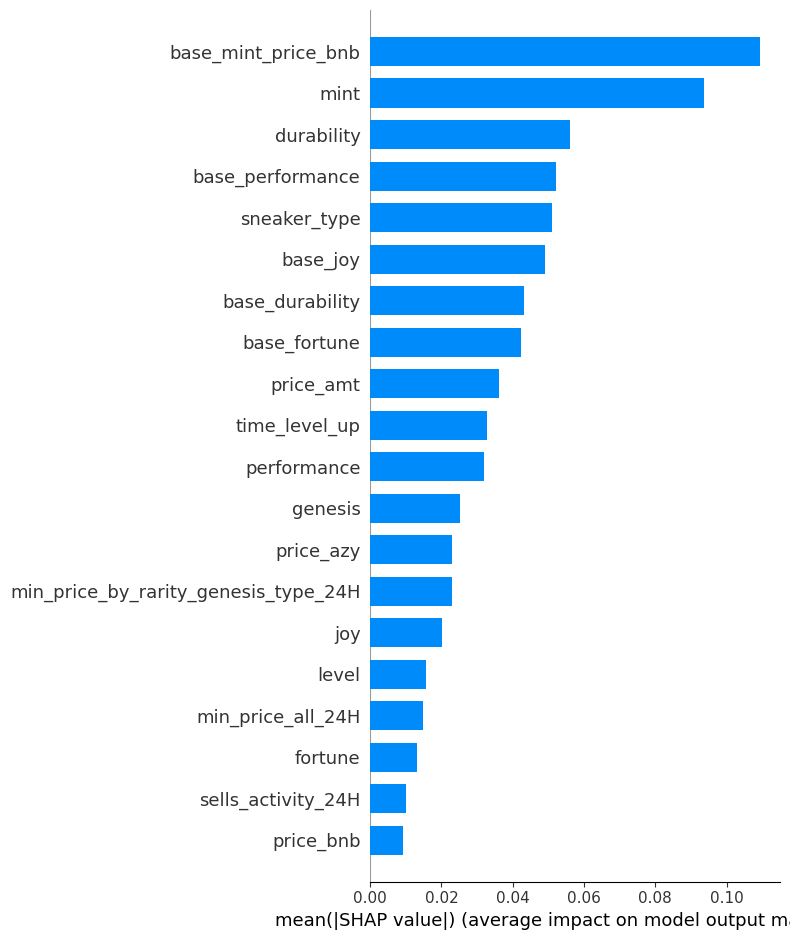

In [57]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [58]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.057924
0:	learn: 1.0152671	total: 3.53ms	remaining: 3.52s
1:	learn: 0.9739170	total: 6.97ms	remaining: 3.48s
2:	learn: 0.9358514	total: 9.91ms	remaining: 3.29s
3:	learn: 0.8967582	total: 12.3ms	remaining: 3.08s
4:	learn: 0.8609366	total: 14.8ms	remaining: 2.95s
5:	learn: 0.8278915	total: 17ms	remaining: 2.82s
6:	learn: 0.7972860	total: 19.4ms	remaining: 2.75s
7:	learn: 0.7679944	total: 21.8ms	remaining: 2.7s
8:	learn: 0.7390071	total: 24.2ms	remaining: 2.67s
9:	learn: 0.7122646	total: 26.6ms	remaining: 2.63s
10:	learn: 0.6882922	total: 28.9ms	remaining: 2.6s
11:	learn: 0.6635951	total: 31.5ms	remaining: 2.59s
12:	learn: 0.6395370	total: 33.9ms	remaining: 2.57s
13:	learn: 0.6166847	total: 36.3ms	remaining: 2.55s
14:	learn: 0.5965795	total: 38.6ms	remaining: 2.53s
15:	learn: 0.5786303	total: 40.9ms	remaining: 2.51s
16:	learn: 0.5608752	total: 43.3ms	remaining: 2.51s
17:	learn: 0.5426118	total: 45.8ms	remaining: 2.5s
18:	learn: 0.5264648	total: 48.2ms	remaining: 2.4

In [59]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.873, 'MAE': 0.101, 'MSE': 0.058, 'RMSE': 0.241, 'MAPE': 0.107}

In [60]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.873, 'MAE': 0.101, 'MSE': 0.058, 'RMSE': 0.241, 'MAPE': 0.107}

In [61]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.873, 'MAE': 0.101, 'MSE': 0.058, 'RMSE': 0.241, 'MAPE': 0.107}

## Fit full Model

In [62]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.059327
0:	learn: 0.9750148	total: 3.59ms	remaining: 3.59s
1:	learn: 0.9328953	total: 7.37ms	remaining: 3.68s
2:	learn: 0.8930431	total: 10.2ms	remaining: 3.38s
3:	learn: 0.8566895	total: 12.8ms	remaining: 3.2s
4:	learn: 0.8224593	total: 15.6ms	remaining: 3.1s
5:	learn: 0.7908335	total: 18.5ms	remaining: 3.07s
6:	learn: 0.7603311	total: 21.5ms	remaining: 3.04s
7:	learn: 0.7320101	total: 24.2ms	remaining: 3s
8:	learn: 0.7049672	total: 26.8ms	remaining: 2.95s
9:	learn: 0.6789119	total: 29.7ms	remaining: 2.94s
10:	learn: 0.6546959	total: 32.5ms	remaining: 2.92s
11:	learn: 0.6312640	total: 35.3ms	remaining: 2.9s
12:	learn: 0.6102793	total: 38.1ms	remaining: 2.9s
13:	learn: 0.5899244	total: 41ms	remaining: 2.89s
14:	learn: 0.5707971	total: 43.8ms	remaining: 2.88s
15:	learn: 0.5520019	total: 46.5ms	remaining: 2.86s
16:	learn: 0.5345407	total: 49.4ms	remaining: 2.85s
17:	learn: 0.5192182	total: 52ms	remaining: 2.84s
18:	learn: 0.5035382	total: 54.7ms	remaining: 2.82s
19:

### Test

In [63]:
i=1800

In [64]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                         sprinter
genesis                                                 False
level                                                     0.0
base_performance                                          8.9
base_fortune                                              8.0
base_joy                                                  7.4
base_durability                                           3.8
performance                                               8.9
fortune                                                   8.0
joy                                                       7.4
durability                                                3.8
mint                                                      0.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.830721
min_pric

In [65]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [66]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.863

In [67]:
data.iloc[i]['price']

0.83

iteritems is deprecated and will be removed in a future version. Use .items instead.


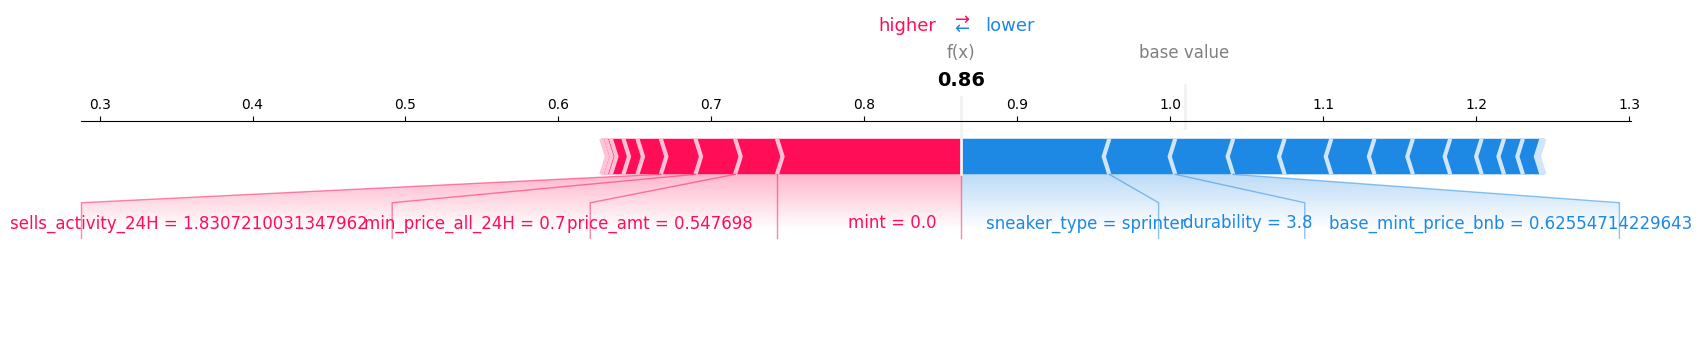

In [68]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [69]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [70]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [71]:
X.genesis.value_counts()

False    7659
True     2799
Name: genesis, dtype: int64

In [72]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10453,common,ranger,False,5.0,2.0,6.5,1.2,1.1,18.0,10.0,1.7,1.6,2.0
10454,common,hiker,False,5.0,6.4,2.2,4.8,8.2,24.4,3.2,7.3,12.2,2.0
10455,common,hiker,True,5.0,7.0,7.4,2.9,9.4,25.5,10.9,4.4,13.9,2.0
10456,common,hiker,True,5.0,7.4,4.0,8.0,6.2,25.9,6.0,12.0,9.2,2.0


In [73]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.15s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.13s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.15s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:08,  2.15s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:10,  2.16s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:12,  2.15s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:15,  2.20s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:17,  2.19s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:19,  2.18s/it]iteritems is deprec

In [74]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.831,0.0387
MAE,0.175,0.0137
MSE,0.182,0.0502
RMSE,0.422,0.0578
MAPE,0.158,0.0047


In [75]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.831,0.0387
MAE,0.175,0.0137
MSE,0.182,0.0502
RMSE,0.422,0.0578
MAPE,0.158,0.0047


In [76]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.839, 'MAE': 0.175, 'MSE': 0.182, 'RMSE': 0.426, 'MAPE': 0.158}

In [77]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


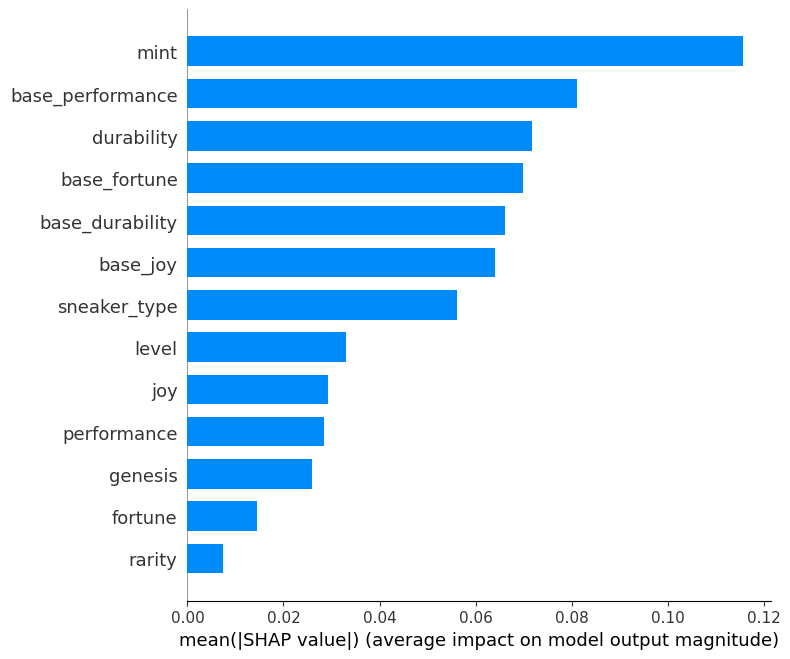

In [78]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [79]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [80]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.057924
0:	learn: 1.0188333	total: 3.27ms	remaining: 3.27s
1:	learn: 0.9788772	total: 6.56ms	remaining: 3.27s
2:	learn: 0.9418052	total: 9.37ms	remaining: 3.11s
3:	learn: 0.9062427	total: 11.9ms	remaining: 2.97s
4:	learn: 0.8730936	total: 14.1ms	remaining: 2.81s
5:	learn: 0.8431470	total: 16.3ms	remaining: 2.7s
6:	learn: 0.8130712	total: 18.4ms	remaining: 2.61s
7:	learn: 0.7841068	total: 20.7ms	remaining: 2.56s
8:	learn: 0.7572848	total: 22.9ms	remaining: 2.52s
9:	learn: 0.7329130	total: 25.2ms	remaining: 2.49s
10:	learn: 0.7102389	total: 27.5ms	remaining: 2.47s
11:	learn: 0.6891363	total: 29.7ms	remaining: 2.45s
12:	learn: 0.6678827	total: 32ms	remaining: 2.43s
13:	learn: 0.6490839	total: 34.3ms	remaining: 2.42s
14:	learn: 0.6318158	total: 36.5ms	remaining: 2.4s
15:	learn: 0.6156125	total: 38.6ms	remaining: 2.38s
16:	learn: 0.6007910	total: 40.8ms	remaining: 2.36s
17:	learn: 0.5871000	total: 43.1ms	remaining: 2.35s
18:	learn: 0.5740094	total: 45.5ms	remaining: 2.

{'R2': 0.441, 'MAE': 0.253, 'MSE': 0.256, 'RMSE': 0.506, 'MAPE': 0.272}

## Fit full Base model

In [81]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.059327
0:	learn: 0.9769585	total: 4.27ms	remaining: 4.27s
1:	learn: 0.9390531	total: 8.3ms	remaining: 4.14s
2:	learn: 0.9013927	total: 11.5ms	remaining: 3.83s
3:	learn: 0.8650874	total: 14.3ms	remaining: 3.56s
4:	learn: 0.8332017	total: 16.8ms	remaining: 3.34s
5:	learn: 0.8032474	total: 19.3ms	remaining: 3.19s
6:	learn: 0.7755909	total: 21.8ms	remaining: 3.09s
7:	learn: 0.7481855	total: 24.3ms	remaining: 3.01s
8:	learn: 0.7233145	total: 26.8ms	remaining: 2.95s
9:	learn: 0.7007730	total: 29.5ms	remaining: 2.92s
10:	learn: 0.6795363	total: 32.3ms	remaining: 2.9s
11:	learn: 0.6602972	total: 35.1ms	remaining: 2.89s
12:	learn: 0.6420331	total: 38ms	remaining: 2.88s
13:	learn: 0.6249099	total: 40.6ms	remaining: 2.86s
14:	learn: 0.6095251	total: 43.3ms	remaining: 2.84s
15:	learn: 0.5937579	total: 46ms	remaining: 2.83s
16:	learn: 0.5793140	total: 48.7ms	remaining: 2.81s
17:	learn: 0.5658991	total: 51.4ms	remaining: 2.81s
18:	learn: 0.5543480	total: 54ms	remaining: 2.79s


### Test

In [82]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [83]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

1.508

iteritems is deprecated and will be removed in a future version. Use .items instead.


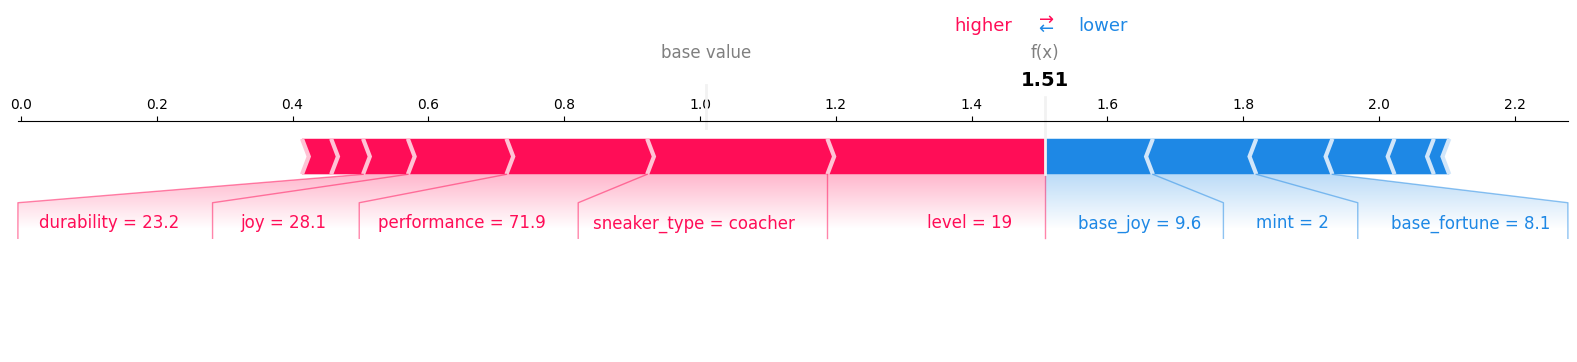

In [84]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


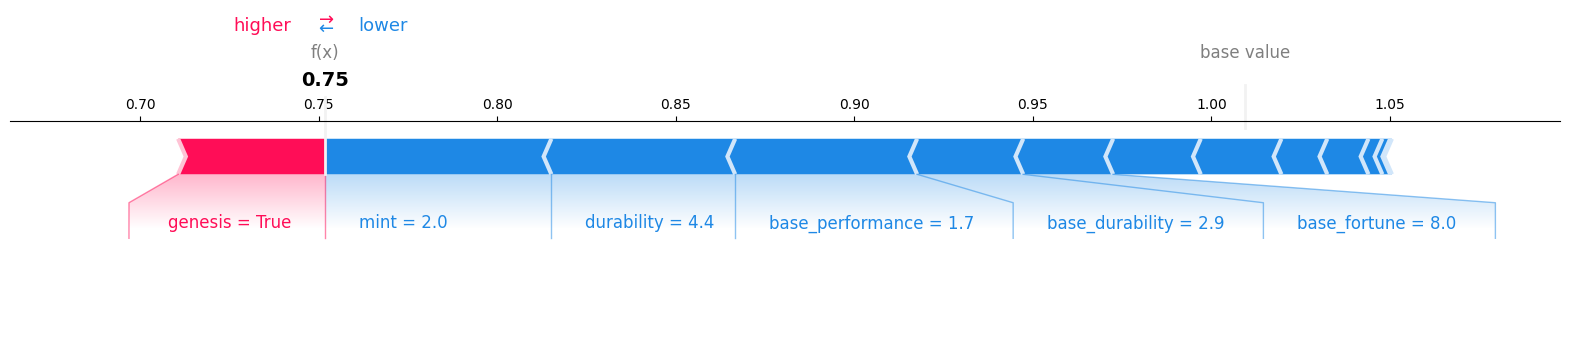

In [85]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [86]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [87]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


In [88]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [89]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664992189,52346,66419,buy,0xfeb49e4862f80db860cfff368fc19efda8b925ce,0x7de958927f1247936b977dc24604438e8a1fe7d2,0.75,box,common,NaN,...,0.75,0.75,0.55,49.0,49.0,49.0,92.0,577.0,99.0,676.0
1,1664984419,52310,66411,buy,0x584ff3a27a02d1e9e1b600d329240450479e0663,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0.75,box,common,NaN,...,0.75,0.75,0.00,49.0,49.0,49.0,92.0,616.0,99.0,715.0
2,1664981323,52277,66400,buy,0xf1a834ef3fbb14b3adbea959396507aa3c88d2d1,0xc285922299bcb92ccbd0ec68024ebf2c29caafd2,0.76,box,common,NaN,...,0.77,0.77,0.50,48.0,48.0,48.0,91.0,629.0,98.0,727.0
3,1664977379,52159,66355,buy,0x5600a698a087824d9e3b3d816dd8518ab093f86a,0x1bb58ab16216ccf96bc99c2c5d456cb018b51192,0.78,box,common,NaN,...,0.77,0.77,0.51,49.0,49.0,49.0,92.0,621.0,99.0,720.0
4,1664977025,50851,63770,buy,0x7fd6f70563996949c3f3ced5ce32270a489f17f2,0x1bb58ab16216ccf96bc99c2c5d456cb018b51192,0.78,box,common,NaN,...,0.77,0.77,0.51,50.0,50.0,50.0,93.0,630.0,100.0,730.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1213,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1214,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1215,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [91]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [92]:
len(data)

1217

In [93]:
len(data[data.date >= START_DATE])

851

In [94]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [95]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
846,1.664796e+09,72134.0,0.0,0.0,NaN,1800.0,300.0,200.0,0.426888
847,1.659582e+09,3608.0,4.0,3.0,NaN,1800.0,300.0,200.0,0.427722
848,1.657893e+09,577.0,5.0,4.0,NaN,1800.0,300.0,200.0,0.428425
849,1.657806e+09,2071.0,12.0,10.0,NaN,1800.0,300.0,200.0,0.428089


In [96]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
846,1664977025,50851,63770,buy,False,ranger,sprinter,2022-10-05 13:37:05
847,1664977379,52159,66355,buy,False,hiker,ranger,2022-10-05 13:42:59
848,1664981323,52277,66400,buy,False,sprinter,hiker,2022-10-05 14:48:43
849,1664984419,52310,66411,buy,False,coacher,hiker,2022-10-05 15:40:19


In [97]:
data.genesis.value_counts()

False    804
True      47
Name: genesis, dtype: int64

In [98]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [99]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [100]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [101]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,1664977025,50851,63770,buy,0x7fd6f70563996949c3f3ced5ce32270a489f17f2,0x1bb58ab16216ccf96bc99c2c5d456cb018b51192,0.78,box,common,NaN,...,1,0,0,0,0,0,0,0,0,0
847,1664977379,52159,66355,buy,0x5600a698a087824d9e3b3d816dd8518ab093f86a,0x1bb58ab16216ccf96bc99c2c5d456cb018b51192,0.78,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0
848,1664981323,52277,66400,buy,0xf1a834ef3fbb14b3adbea959396507aa3c88d2d1,0xc285922299bcb92ccbd0ec68024ebf2c29caafd2,0.76,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
849,1664984419,52310,66411,buy,0x584ff3a27a02d1e9e1b600d329240450479e0663,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0.75,box,common,NaN,...,0,0,0,0,0,1,0,0,0,0


In [102]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [103]:
data['ranger_hiker'].sum()

81

## FE

In [104]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [105]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [106]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [107]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.20it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.24it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:02,  1.26it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:03,  1.27it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:05,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:06,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:07,  1.28it/s]iteritems is deprec

In [108]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.609,0.9682
MAE,0.087,0.0721
MSE,0.363,0.8301
RMSE,0.349,0.4993
MAPE,0.049,0.0117


In [109]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.609,0.9682
MAE,0.087,0.0721
MSE,0.363,0.8301
RMSE,0.349,0.4993
MAPE,0.049,0.0117


In [110]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.389, 'MAE': 0.087, 'MSE': 0.362, 'RMSE': 0.602, 'MAPE': 0.049}

iteritems is deprecated and will be removed in a future version. Use .items instead.


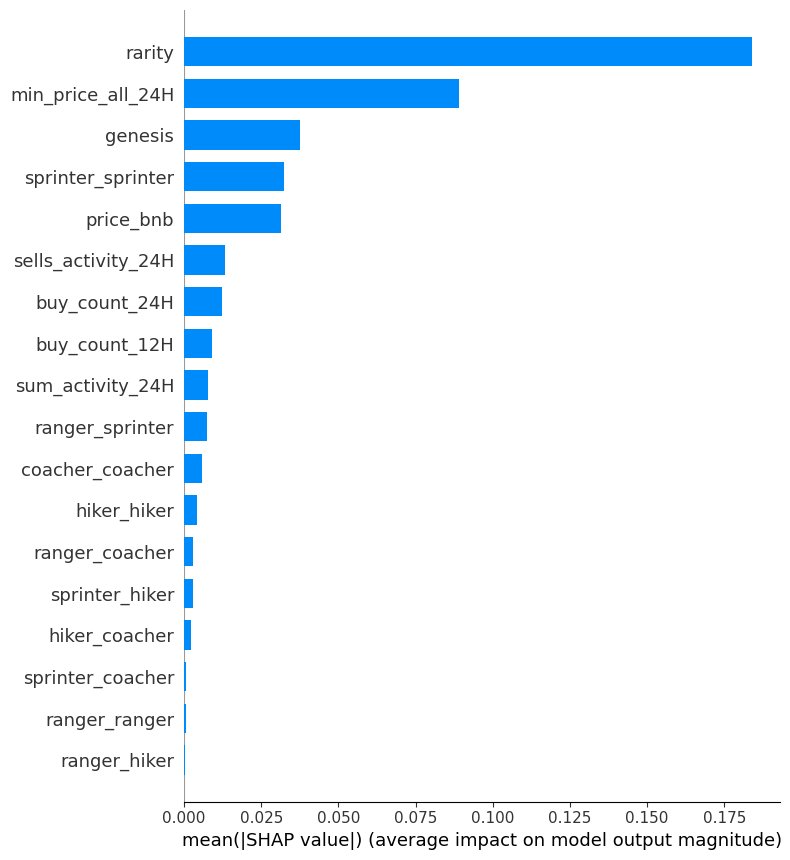

In [111]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [112]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.039912
0:	learn: 0.7564416	total: 1.59ms	remaining: 1.59s
1:	learn: 0.7429252	total: 2.87ms	remaining: 1.43s
2:	learn: 0.7325915	total: 4.14ms	remaining: 1.38s
3:	learn: 0.7192350	total: 5.34ms	remaining: 1.33s
4:	learn: 0.7070704	total: 6.3ms	remaining: 1.25s
5:	learn: 0.6948711	total: 7.06ms	remaining: 1.17s
6:	learn: 0.6832318	total: 8.07ms	remaining: 1.15s
7:	learn: 0.6719841	total: 8.92ms	remaining: 1.11s
8:	learn: 0.6595625	total: 9.67ms	remaining: 1.06s
9:	learn: 0.6481729	total: 10.4ms	remaining: 1.03s
10:	learn: 0.6367627	total: 10.9ms	remaining: 978ms
11:	learn: 0.6259012	total: 11.6ms	remaining: 957ms
12:	learn: 0.6151113	total: 12.3ms	remaining: 933ms
13:	learn: 0.6036602	total: 13ms	remaining: 912ms
14:	learn: 0.5936877	total: 13.6ms	remaining: 893ms
15:	learn: 0.5843037	total: 14.3ms	remaining: 879ms
16:	learn: 0.5744038	total: 15ms	remaining: 865ms
17:	learn: 0.5649594	total: 15.6ms	remaining: 851ms
18:	learn: 0.5548380	total: 16.3ms	remaining: 841

### Test

In [113]:
i = 250

In [114]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2.0,
 'wallet_from_all_count': 9.0,
 'token_all_activity_3H': 0.0,
 'token_sell_activity_6H': 0.0,
 'buy_count_12H': 16.0,
 'buy_count_24H': 25,
 'buy_count_48H': 55.0,
 'sell_count_12H': 18.0,
 'sell_count_24H': 40,
 'sell_count_48H': 96.0,
 'cancel_count_12H': 9.0,
 'cancel_count_24H':

In [115]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H              16.0
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count       2.0
wallet_from_all_count       9.0
dtype: object

In [116]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.02

In [117]:
data.iloc[i]['price']

1.0

In [118]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.42

In [119]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.639

# Box Base Model

In [120]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [121]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [122]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             851 non-null    object
 1   genesis            851 non-null    bool  
 2   ranger_sprinter    851 non-null    int64 
 3   ranger_hiker       851 non-null    int64 
 4   ranger_coacher     851 non-null    int64 
 5   sprinter_hiker     851 non-null    int64 
 6   sprinter_coacher   851 non-null    int64 
 7   hiker_coacher      851 non-null    int64 
 8   ranger_ranger      851 non-null    int64 
 9   sprinter_sprinter  851 non-null    int64 
 10  hiker_hiker        851 non-null    int64 
 11  coacher_coacher    851 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 74.1+ KB


In [124]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  1.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:03,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:04,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  1.97it/s]iteritems is deprec

In [125]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.683,0.2825
MAE,0.159,0.0704
MSE,0.345,0.8194
RMSE,0.378,0.4568
MAPE,0.136,0.0166


In [126]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.683,0.2825
MAE,0.159,0.0704
MSE,0.345,0.8194
RMSE,0.378,0.4568
MAPE,0.136,0.0166


In [127]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.42, 'MAE': 0.159, 'MSE': 0.344, 'RMSE': 0.587, 'MAPE': 0.136}

iteritems is deprecated and will be removed in a future version. Use .items instead.


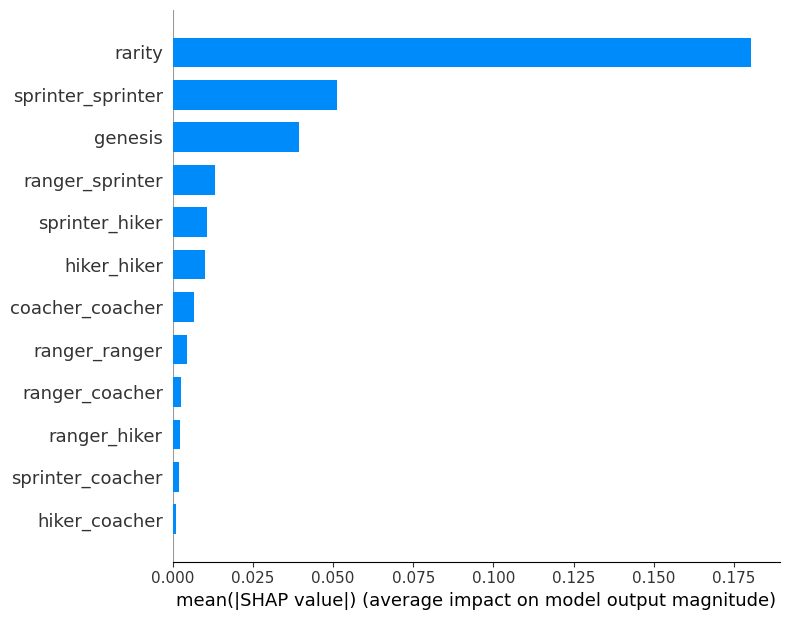

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [129]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.039912
0:	learn: 0.7589437	total: 702us	remaining: 702ms
1:	learn: 0.7457943	total: 1.52ms	remaining: 761ms
2:	learn: 0.7347898	total: 2.17ms	remaining: 722ms
3:	learn: 0.7243183	total: 2.59ms	remaining: 645ms
4:	learn: 0.7136933	total: 3.34ms	remaining: 665ms
5:	learn: 0.7037481	total: 4.02ms	remaining: 666ms
6:	learn: 0.6939198	total: 4.44ms	remaining: 630ms
7:	learn: 0.6851496	total: 5.08ms	remaining: 630ms
8:	learn: 0.6764644	total: 5.66ms	remaining: 623ms
9:	learn: 0.6677682	total: 6.53ms	remaining: 646ms
10:	learn: 0.6586757	total: 6.96ms	remaining: 626ms
11:	learn: 0.6513180	total: 7.64ms	remaining: 629ms
12:	learn: 0.6435165	total: 8.32ms	remaining: 632ms
13:	learn: 0.6354564	total: 9.07ms	remaining: 639ms
14:	learn: 0.6279356	total: 9.7ms	remaining: 637ms
15:	learn: 0.6215708	total: 9.95ms	remaining: 612ms
16:	learn: 0.6160735	total: 10.3ms	remaining: 598ms
17:	learn: 0.6100710	total: 10.9ms	remaining: 597ms
18:	learn: 0.6038777	total: 11.4ms	remaining: 

## Test

In [130]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.473

In [131]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [132]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [133]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [134]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.978

In [135]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.999

In [136]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.999

In [137]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.423

In [138]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.059

In [139]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

0.996

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [140]:
# import ast
# import json

In [141]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [142]:
# print(json.dumps(json_data))

In [143]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [144]:
#output = json.loads(r.text)

In [145]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам